# WIKI-SHEAF

@ Alessio Borgi
@ Stefano Previti

### 0: IMPORTING LIBRARIES

In [ ]:
!pip install requests datasets networkx matplotlib torch torch-geometric sentence-transformers torch_scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:0

In [ ]:
### LIBRARIES NECESSARY FROM STEP 0 ON ###
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

### LIBRARIES NECESSARY FROM STEP 2 ON ###
import torch
import random
import itertools
import networkx as nx
from torch_geometric.utils import from_networkx
from sklearn.feature_extraction.text import TfidfVectorizer

import os
import torch
import numpy as np
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Sequential, ReLU, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score
from torch_geometric.nn import GCNConv, BatchNorm, GATConv, SAGEConv, GINConv

import torch.nn as nn
from torch_scatter import scatter_add
from torch_geometric.nn.norm import GraphNorm

from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses

# Only necessary if you take the dataset from the drive instead from HuggingFace.
from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Mounted at /content/drive


### 1:  ORIGINAL DATASET

In [ ]:
# Login beforehand using huggingface-cli login if necessary.
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_data = ds["train"]
validation_data = ds["validation"]

# Create Pandas Dataframes just for better analysis.
train_df = train_data.to_pandas()
validation_df = validation_data.to_pandas()


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
train_df.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive


In [ ]:
validation_df.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative


### 2: GRAPH CONSTRUCTION

In this section, we will proceed to build the big one-graph from the dataset and we will associate to them some embeddings (with different techniques). After that, we will run over them some typical Graph Models, but also more particular and difficult ones.

####2.1: (BASELINE) TF–IDF + Category/Subcategory Clique Graph

In this first **Baseline**, we represent each cultural item as a node in a **homogeneous graph**, using its name and description to build a **1 000‑dimensional TF–IDF(Term Frequency–Inverse Document Frequency) feature vector**.  **Edges** are then added by **fully connecting (“clique‐ing”)** all items that share the same high‑level category or fine‑grained subcategory, encoding cultural similarity purely via our provided taxonomy.  We also create train/validation masks on the nodes so that downstream GNNs can be trained and evaluated in a standard node‐classification setup. Notice that this is just a very basic construction that provides only a starting point before moving on to more sophisticated graph types or feature enhancements.  

--------------------------
**TF–IDF FEATURE VECTOR**

*(Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)*

In this baseline graph, each node corresponds to a cultural item with two text fields: **name** and **description**.  To turn these into fixed‑length numeric features that capture the most distinctive words for each item, we compute a **TF–IDF** vector.

- **Tokenization and Vocabulary:** The *TfidfVectorizer* we employ, by default:
  - Splits each “name + description” string on whitespace and punctuation.
  - Converts all text to lowercase.
  - Builds a vocabulary of the top `max_features` $(\leq 1\,000)$ terms ranked by overall TF–IDF score.

- **Term Frequency (TF):** For a given item $d$ and term $t$, we have that this captures how often $t$ appears **within** this item’s text.
:
$$\begin{equation}
  \mathrm{TF}(t, d) \;=\; \frac{\text{count of }t\text{ in }d}{\text{total terms in }d}.
  \end{equation}
$$

- **Inverse Document Frequency (IDF):** Over the entire corpus of $N$ items  (with $\lvert\{d : t \in d\}\rvert$ being the number of items containing $t$), we have that rarer terms get a higher IDF weight.:
$$\begin{equation}
  \mathrm{IDF}(t) \;=\; \log\!\Bigl(\frac{N}{1 + \lvert\{\,d : t \in d\}\rvert}\Bigr),
  \end{equation}
$$

- **Combining TF and IDF:** The **TF–IDF** weight for term $t$ in document $d$ is:
$$\begin{equation}
  \mathrm{TF\mbox{–}IDF}(t, d) \;=\; \mathrm{TF}(t, d) \times \mathrm{IDF}(t).
  \end{equation}
$$

One can interpret this information as follows:
- **High TF–IDF** --> term is common in this item but rare across all items.
- **Low TF–IDF** --> term is either too common everywhere or too rare in this item.

--------------------------
**1. DATA PREPARATION & SPLIT**

- We begin by adding to the **train** and **validation** DataFrames, one item per row with the columns: (`item`, `name`,
 `description`, `type`, `category` and `subcategory`, `label`.
- We tag each row with a `split` column (`'train'` vs `'val'`) and then also concatenate both sets into a single DataFrame `df`.  
- We also create explicit boolean masks (`train_mask`, `val_mask`) so we can later index into our graph object for training vs validation.  

**2. BUILDING THE GRAPH TOPOLOGY**

- We instantiate an empty **NetworkX** graph `G`.  
- **Nodes** correspond one‑to‑one with rows in `df` (by integer index) and e store each node’s `category` and `subcategory` and the `train_mask`/`val_mask` flags.

- We connect nodes via **clique edges** on shared categorical membership:
  1. For each unique **category**, fully connect (make a clique of) all items in that category.
  2. Repeat for each **subcategory**.  

  With this, we aim to build a homogeneous item–item graph where edges encode broad or narrow cultural similarity.

**3. COMPUTING NODE FEATURES**

- We represent each item with a **TF–IDF** vector over the concatenated `"name + description"` text:
  1. Collect all `name + description` strings into a list of length $n$.  
  2. fit+transform a `TfidfVectorizer(max_features=1000)` to obtain an $[n \times 1000]$ dense array.  

- These 1,000‑dim vectors become our initial node features `x`.

**4. LABEL ENCODING**

- We map the three textual labels to integer IDs:
  {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2
  }


In [ ]:
# 1) Data Preparation and Split.
train_df = train_df.copy()
val_df   = validation_df.copy()
train_df['split'] = 'train'
val_df  ['split'] = 'val'
df = pd.concat([train_df, val_df], ignore_index=True)
df['train_mask'] = df['split'] == 'train'
df['val_mask']   = df['split'] == 'val'
n = len(df)

# 2) Build a NetworkX graph.
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i,
               category    = row['category'],
               subcategory = row['subcategory'],
               train_mask  = bool(row['train_mask']),
               val_mask    = bool(row['val_mask'])
              )

# 2.1) Clique‐connect by category & subcategory.
for attr in ['category','subcategory']:
    for _, idxs in df.groupby(attr).groups.items():
        for u, v in itertools.combinations(idxs, 2):
            G.add_edge(u, v)

# 3) Computing Node Features (TF–IDF features on "name + description").
texts = (df['name'] + " " + df['description']).tolist()
tfidf = TfidfVectorizer(max_features=1_000)
X = tfidf.fit_transform(texts).toarray()   # The shape here is therefore [n,1000].

# 4) Label Encoding.
label_map = {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2,
}
Y = df['label'].map(label_map).astype(int).values

# Stash x, y, and masks on nodes.
for i in range(n):
    G.nodes[i]['x']          = X[i]
    G.nodes[i]['y']          = int(Y[i])
    G.nodes[i]['train_mask'] = G.nodes[i]['train_mask']
    G.nodes[i]['val_mask']   = G.nodes[i]['val_mask']

# Convert to torch_geometric.Data.
tdidf_graph_data = from_networkx(G)

# Fix necessary in order to satisfy the dtypes/names to PyG conventions.
tdidf_graph_data.x           = tdidf_graph_data.x.float()          # Shape here: [n,1000].
tdidf_graph_data.y           = tdidf_graph_data.y.long()           # Shape here: [n].
tdidf_graph_data.train_mask  = tdidf_graph_data.train_mask.bool()  # Shape here: [n].
tdidf_graph_data.val_mask    = tdidf_graph_data.val_mask.bool()    # Shape here: [n].
print(tdidf_graph_data)


Data(x=[6551, 1000], edge_index=[2, 2369932], y=[6551], category=[6551], subcategory=[6551], train_mask=[6551], val_mask=[6551])


/usr/local/lib/python3.11/dist-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data_dict[key] = torch.as_tensor(value)


##### 2.1.1: ORIGINAL, SAMPLED SUBGRAPH and 2 BIGGEST CLIQUES VISUALIZATION

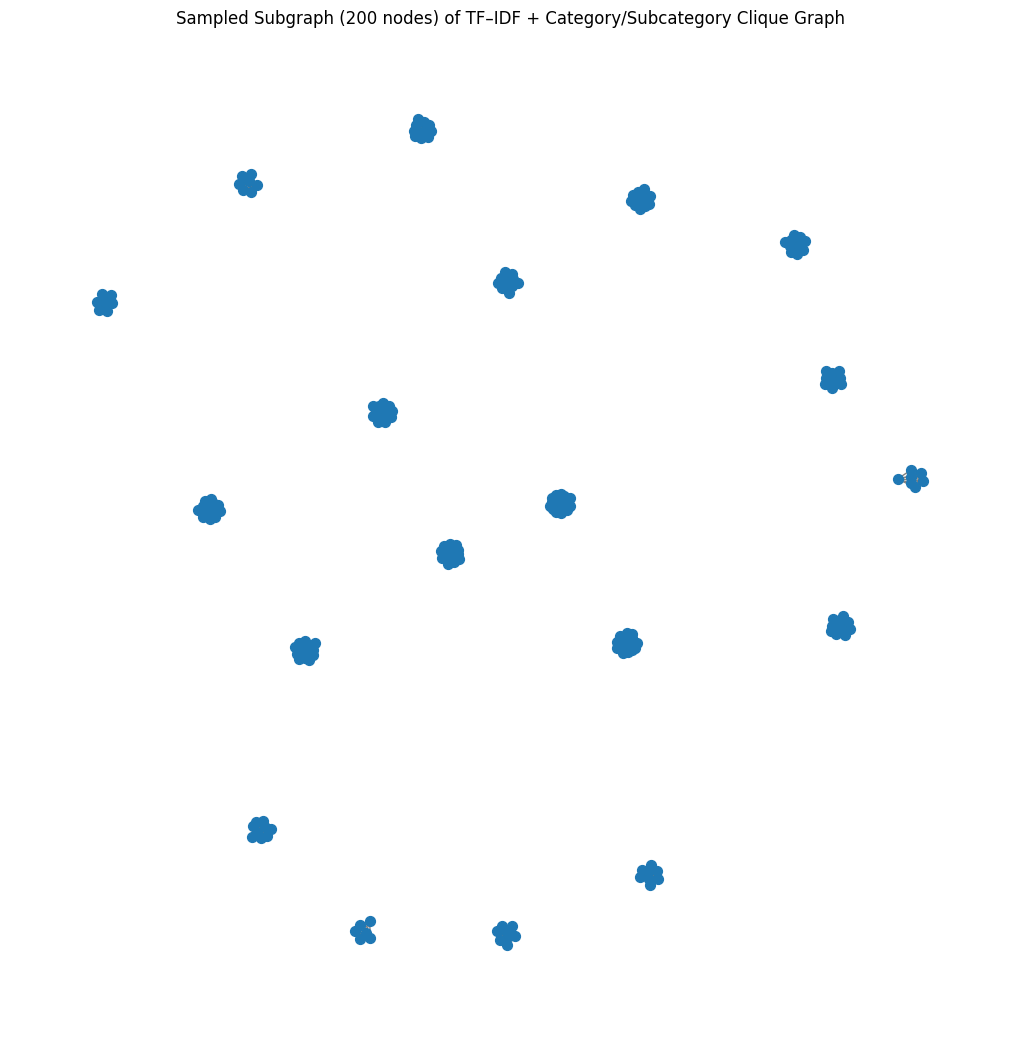

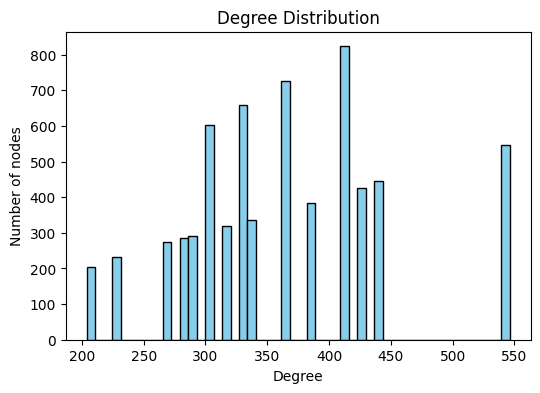

In [ ]:
# Plot entire Graph.
# 1) Color maps for nodes.
label_names = {
    0: 'cultural agnostic',
    1: 'cultural representative',
    2: 'cultural exclusive'
}
label_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:green'
}
node_colors = [
    label_colors[G.nodes[n]['y']]
    for n in G.nodes()
]

# 2) Edge colors for all edges.
edge_colors = [
    'red' if G.nodes[u]['y'] != G.nodes[v]['y'] else 'lightgray'
    for u, v in G.edges()
]


# 3) Plot the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12,12))
nx.draw(
    G, pos,
    node_size=20,
    node_color=node_colors,
    edge_color=edge_colors,
    with_labels=False,
    alpha=0.8
)

# 4) Build legend.
legend_patches = [
    Patch(color=color, label=label_names[label])
    for label, color in label_colors.items()
]
legend_patches.append(Patch(color='red', label='heterophilous edge'))

plt.legend(
    handles=legend_patches,
    loc='lower left',
    fontsize='small',
    frameon=True
)
plt.title("Full Graph: Nodes Colored by Label, Red=Heterophilous Edges")
plt.axis('off')
plt.show()


In [ ]:
# Plot a subgraph of 200 random nodes.
# 1) Sample 200 random nodes.
sample_nodes = random.sample(list(G.nodes()), 200)
subG = G.subgraph(sample_nodes)
pos = nx.spring_layout(subG, seed=42)

# 1.5) Build color maps for the nodes.
pos = nx.spring_layout(subG, seed=42)
node_colors = [ label_colors[G.nodes[n]['y']] for n in subG.nodes() ]

# 1.75) Build color maps for the edges.
edge_colors = [
    'red' if G.nodes[u]['y'] != G.nodes[v]['y'] else 'lightgray'
    for u, v in subG.edges()
]

# 2) Draw the subgraph.
plt.figure(figsize=(10, 10))
nx.draw(subG, pos,
        node_size=10,
        node_color=node_colors,
        edge_color=edge_colors,
        with_labels=False)
plt.title("Sampled Subgraph with Node‐Labels & Heterophilous Edges Highlighted")
legend_patches = [
    Patch(color=color, label=label_names[label])
    for label, color in label_colors.items()
]
legend_patches.append(Patch(color='red', label='heterophilous edge'))
plt.legend(handles=legend_patches, loc='lower left')

plt.show()

In [ ]:
# Show the 2 biggest cliques from original graph (zoomed in).

# 1) Find and sort all maximal cliques by size.
cliques = list(nx.find_cliques(G))
cliques_sorted = sorted(cliques, key=len, reverse=True)

# 2) Take the top-2 largest cliques.
top_cliques = cliques_sorted[:2]

# Decide here how many nodes per clique to actually plot. (default=31)
k = 31

for idx, clique in enumerate(top_cliques, start=1):
    # 2.1) sample up to k nodes from this clique.
    sub_nodes = random.sample(clique, min(k, len(clique)))
    subG = G.subgraph(sub_nodes)

    # 2.2) node colors by label and edge colors (red if heterophilic)
    pos = nx.spring_layout(subG, seed=42)
    node_colors = [ label_colors[G.nodes[n]['y']] for n in subG.nodes() ]
    edge_colors = [
        'red' if G.nodes[u]['y'] != G.nodes[v]['y'] else 'lightgray'
        for u, v in subG.edges()
    ]

    # 2.3) Draw this subset‐clique.
    plt.figure(figsize=(6,6))
    nx.draw(
        subG, pos,
        node_size=300,
        node_color=node_colors,
        edge_color=edge_colors,
        with_labels=True
    )
    plt.title(f"Clique {idx} (showing {len(sub_nodes)}/{len(clique)} nodes)")

    # 2.4) Legend.
    legend_elems = [
        Patch(color=color, label=name)
        for name, color in [
            ('cultural agnostic',     label_colors[0]),
            ('cultural representative', label_colors[1]),
            ('cultural exclusive',    label_colors[2]),
        ]
    ]
    legend_elems.append(Patch(color='red', label='heterophilous edge'))
    plt.legend(handles=legend_elems, loc='best')

    plt.show()


##### 2.1.2: DEFINE UTILS FUNCTIONS & BASIC PARAMS

In [ ]:
def setup_training(data, seed = 42):
    """
    Utils function to set random seeds, moves data to the appropriate device, computes class weights
    for imbalanced cross‑entropy.
    """

    # 1) Set seeds for reproducibility.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
    os.environ["PYTHONHASHSEED"]       = str(seed)

    # 2) Device & move data.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data   = data.to(device)

    # 3) Compute class weights for imbalanced cross-entropy.
    train_y      = data.y[data.train_mask]
    class_counts = torch.bincount(train_y)
    # Inverse frequency.
    class_weights = 1.0 / (class_counts.float() + 1e-6)
    # Re‑scale so weights sum to #classes.
    class_weights = class_weights / class_weights.sum() * class_counts.numel()
    class_weights = class_weights.to(device)

    return device, data, class_weights


In [ ]:
# Setup the training.
device, data, class_weights = setup_training(tdidf_graph_data, seed=42)

# Basic Params.
patience       = 50
best_val_loss  = float('inf')
epochs_no_imp  = 0
max_epochs     = 200
best_state     = None

In [ ]:
def train_model(model, data, class_weights, patience, max_epochs):

    # Set basic info.
    best_val_loss = float('inf')
    epochs_no_imp = 0
    best_state    = None

    # Optimizer, Scheduler & Early Stopping setup.
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-3,
                                weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=50,
                                                gamma=0.5)

    for epoch in range(1, max_epochs+1):

        # Training step.
        model.train()
        optimizer.zero_grad()
        out   = model(data.x, data.edge_index)
        loss  = F.cross_entropy(out[data.train_mask],
                                data.y[data.train_mask],
                                weight=class_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Validation step.
        model.eval()
        with torch.no_grad():
            logits     = model(data.x, data.edge_index)
            val_logits = logits[data.val_mask]
            val_labels = data.y[data.val_mask]
            val_loss   = F.cross_entropy(val_logits, val_labels).item()

        # Check Early Stopping.
        if val_loss + 1e-4 < best_val_loss:
            best_val_loss = val_loss
            epochs_no_imp = 0
            best_state    = model.state_dict()
        else:
            epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Print results every 10 epochs.
        if epoch % 10 == 0:
            # compute metrics
            preds = val_logits.argmax(dim=1)
            acc   = (preds == val_labels).float().mean().item()
            y_t   = val_labels.cpu().numpy()
            y_p   = preds.cpu().numpy()
            prec  = precision_score(y_t, y_p, average='macro', zero_division=0)
            rec   = recall_score(   y_t, y_p, average='macro', zero_division=0)
            f1    = f1_score(       y_t, y_p, average='macro', zero_division=0)
            ppl   = torch.exp(torch.tensor(val_loss)).item()

            print(f"[Epoch {epoch:03d}] "
                  f"Train Loss: {loss:.4f}  "
                  f"Val Loss:   {val_loss:.4f}  "
                  f"Val Acc:    {acc:.4f}  "
                  f"Prec:       {prec:.4f}  "
                  f"Rec:        {rec:.4f}  "
                  f"F1:         {f1:.4f}  "
                  f"PPL:        {ppl:.2f}")

    return best_state, best_val_loss


In [ ]:
def evaluate_model(model, data, best_state, best_val_loss):

    # Loading the model and put it into evaluation mode.
    model.load_state_dict(best_state)
    model.eval()

    # Evaluate.
    with torch.no_grad():
        logits     = model(data.x, data.edge_index)[data.val_mask]
        labels     = data.y[data.val_mask]
        preds      = logits.argmax(dim=1)
        acc        = (preds == labels).float().mean().item()
        y_t        = labels.cpu().numpy()
        y_p        = preds.cpu().numpy()
        prec       = precision_score(y_t, y_p, average='macro', zero_division=0)
        rec        = recall_score(   y_t, y_p, average='macro', zero_division=0)
        f1         = f1_score(       y_t, y_p, average='macro', zero_division=0)
        ppl        = torch.exp(torch.tensor(best_val_loss)).item()

    print(f"\nBest Val Loss: {best_val_loss:.4f}")
    print(f"Final Val Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, "
          f"F1: {f1:.4f}, PPL: {ppl:.2f}")

    return {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'ppl':ppl}

##### 2.1.2: GCN ("GRAPH CONVOLUTIONAL NETWORK")

In [ ]:
# 3‑layer GCN Model (1 hidden) with residual + BatchNorm.
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1   = GCNConv(in_dim, hid_dim)
        self.bn1     = BatchNorm1d(hid_dim)

        # 2) Hidden layer.
        self.conv2   = GCNConv(hid_dim, hid_dim)
        self.bn2     = BatchNorm1d(hid_dim)

        # 3) Output layer.
        self.conv3   = GCNConv(hid_dim, out_dim)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [ ]:
# 1) Instantiate GCN Model.
GCN_model = GCN(in_dim = tdidf_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GCN_model, tdidf_graph_data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GCN_model, tdidf_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 1.0896  Val Loss:   1.0829  Val Acc:    0.3933  Prec:       0.4638  Rec:        0.3364  F1:         0.1937  PPL:        2.95
[Epoch 020] Train Loss: 0.9948  Val Loss:   1.0867  Val Acc:    0.3433  Prec:       0.5470  Rec:        0.3941  F1:         0.3228  PPL:        2.96
[Epoch 030] Train Loss: 0.9684  Val Loss:   1.0959  Val Acc:    0.2733  Prec:       0.6003  Rec:        0.3441  F1:         0.1948  PPL:        2.99
[Epoch 040] Train Loss: 0.9583  Val Loss:   1.0907  Val Acc:    0.2867  Prec:       0.5785  Rec:        0.3464  F1:         0.2312  PPL:        2.98
[Epoch 050] Train Loss: 0.9494  Val Loss:   1.0744  Val Acc:    0.3533  Prec:       0.5856  Rec:        0.3965  F1:         0.3095  PPL:        2.93
[Epoch 060] Train Loss: 0.9444  Val Loss:   1.0622  Val Acc:    0.4333  Prec:       0.5326  Rec:        0.4539  F1:         0.4305  PPL:        2.89
[Epoch 070] Train Loss: 0.9405  Val Loss:   1.0478  Val Acc:    0.4400  Prec:       0.5114  Rec:        0.

##### 2.1.3: GAT("GRAPH ATTENTION NETWORK")

In [ ]:
# 3‑layer GAT Model (1 hidden) with residual + BatchNorm.
class GAT(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 heads=4, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1 = GATConv(in_dim, hid_dim, heads=heads, dropout=dropout)
        self.bn1   = BatchNorm1d(hid_dim * heads)

        # 2) Hidden layer.
        self.conv2 = GATConv(hid_dim * heads, hid_dim, heads=heads, dropout=dropout)
        self.bn2   = BatchNorm1d(hid_dim * heads)

        # 3) Output layer.
        self.conv3 = GATConv(hid_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [ ]:
# 1) Instantiate GCN Model.
GAT_model = GAT(in_dim = tdidf_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GAT_model, tdidf_graph_data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GAT_model, tdidf_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 1.0275  Val Loss:   1.0793  Val Acc:    0.5100  Prec:       0.3947  Rec:        0.4623  F1:         0.3875  PPL:        2.94
[Epoch 020] Train Loss: 0.9874  Val Loss:   1.0670  Val Acc:    0.5433  Prec:       0.3615  Rec:        0.4841  F1:         0.4139  PPL:        2.91
[Epoch 030] Train Loss: 0.9709  Val Loss:   1.0582  Val Acc:    0.5800  Prec:       0.6045  Rec:        0.5236  F1:         0.4790  PPL:        2.88
[Epoch 040] Train Loss: 0.9654  Val Loss:   1.0472  Val Acc:    0.5667  Prec:       0.5334  Rec:        0.5207  F1:         0.4994  PPL:        2.85
[Epoch 050] Train Loss: 0.9546  Val Loss:   1.0345  Val Acc:    0.4833  Prec:       0.4618  Rec:        0.4618  F1:         0.4617  PPL:        2.81
[Epoch 060] Train Loss: 0.9470  Val Loss:   1.0311  Val Acc:    0.4533  Prec:       0.4522  Rec:        0.4446  F1:         0.4449  PPL:        2.80
[Epoch 070] Train Loss: 0.9402  Val Loss:   1.0307  Val Acc:    0.4767  Prec:       0.4882  Rec:        0.

##### 2.1.4: GRAPHSAGE

In [ ]:
# 3‑layer GraphSAGE Model (1 hidden) with residual + BatchNorm.
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1   = SAGEConv(in_dim, hid_dim)
        self.bn1     = BatchNorm1d(hid_dim)

        # 2) Hidden layer.
        self.conv2   = SAGEConv(hid_dim, hid_dim)
        self.bn2     = BatchNorm1d(hid_dim)

        # 3) Output layer.
        self.conv3   = SAGEConv(hid_dim, out_dim)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [ ]:
# 1) Instantiate GCN Model.
GraphSAGE_model = GraphSAGE(in_dim = tdidf_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GraphSAGE_model, tdidf_graph_data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GraphSAGE_model, tdidf_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 0.8877  Val Loss:   1.0877  Val Acc:    0.3900  Prec:       0.1300  Rec:        0.3333  F1:         0.1871  PPL:        2.97
[Epoch 020] Train Loss: 0.7419  Val Loss:   1.0693  Val Acc:    0.3900  Prec:       0.1300  Rec:        0.3333  F1:         0.1871  PPL:        2.91
[Epoch 030] Train Loss: 0.6288  Val Loss:   1.0243  Val Acc:    0.4600  Prec:       0.6574  Rec:        0.4232  F1:         0.3359  PPL:        2.79
[Epoch 040] Train Loss: 0.5577  Val Loss:   0.9578  Val Acc:    0.5833  Prec:       0.6220  Rec:        0.5682  F1:         0.5187  PPL:        2.61
[Epoch 050] Train Loss: 0.4941  Val Loss:   0.8702  Val Acc:    0.6100  Prec:       0.5997  Rec:        0.5991  F1:         0.5713  PPL:        2.39
[Epoch 060] Train Loss: 0.4568  Val Loss:   0.8050  Val Acc:    0.6400  Prec:       0.6257  Rec:        0.6304  F1:         0.6132  PPL:        2.24
[Epoch 070] Train Loss: 0.4343  Val Loss:   0.7897  Val Acc:    0.6467  Prec:       0.6260  Rec:        0.

##### 2.1.5: GIN ("GRAPH ISOMORPHISM NETWORK")  

In [ ]:
# 3‑layer GIN Model (1 hidden) with residual + BatchNorm.
class GIN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1   = GINConv(Sequential(
            Linear(in_dim, hid_dim), ReLU(),
            Linear(hid_dim, hid_dim), ReLU()
        ))
        self.bn1     = BatchNorm1d(hid_dim)

        # 2) Hidden layer.
        self.conv2   = GINConv(Sequential(
            Linear(hid_dim, hid_dim), ReLU(),
            Linear(hid_dim, hid_dim), ReLU()
        ))
        self.bn2     = BatchNorm1d(hid_dim)

        # 3) Output layer.
        self.conv3   = GINConv(Sequential(
            Linear(hid_dim, hid_dim), ReLU(),
            Linear(hid_dim, out_dim),   ReLU()
        ))

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [ ]:
# 1) Instantiate GCN Model.
GIN_model = GIN(in_dim = tdidf_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GIN_model, tdidf_graph_data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GIN_model, tdidf_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 1.8339  Val Loss:   3.8445  Val Acc:    0.3700  Prec:       0.4793  Rec:        0.3964  F1:         0.3587  PPL:        46.73
[Epoch 020] Train Loss: 1.0671  Val Loss:   1.0963  Val Acc:    0.4400  Prec:       0.5403  Rec:        0.4551  F1:         0.4337  PPL:        2.99
[Epoch 030] Train Loss: 1.0733  Val Loss:   14.7788  Val Acc:    0.5067  Prec:       0.5604  Rec:        0.5080  F1:         0.5018  PPL:        2620191.75
[Epoch 040] Train Loss: 1.0631  Val Loss:   1.0695  Val Acc:    0.5667  Prec:       0.5715  Rec:        0.5605  F1:         0.5611  PPL:        2.91
[Epoch 050] Train Loss: 1.0529  Val Loss:   1.0611  Val Acc:    0.5900  Prec:       0.5787  Rec:        0.5755  F1:         0.5761  PPL:        2.89
[Epoch 060] Train Loss: 1.0474  Val Loss:   1.0570  Val Acc:    0.5933  Prec:       0.5763  Rec:        0.5768  F1:         0.5764  PPL:        2.88
[Epoch 070] Train Loss: 1.0424  Val Loss:   1.0530  Val Acc:    0.6100  Prec:       0.5885  Rec:  

##### 2.1.6: SHEAF NEURAL NETWORKS

**INTERPRETING EDGE HOMOPHILY VS HERETOPHILY**

We also decided to look at the degree of **Heretophily** that our graph has. Indeed, if >0.5, this means that maybe a **Sheaf Neural Network** could better help.

- **Edge Homophily:** The fraction of edges in the graph that connect nodes **of the same class**.  Here we have:
  - **High Homophily (close to 1.0)**: This means that **most neighbors share the same label**.  
  - **Standard/Low Homophily (<0.5)**: Standard GNNs (e.g. GCN, GAT) assume homophily: they smooth a node's features with its neighbors'.

- **Edge Heterophily**  
  The fraction of edges that connect nodes **of different classes**. When most edges cross labels, smoothing can actually *mix* conflicting signals, hurting performance. This is of course defined as:
  $$\text{Heterophily} = 1 − \text{Homophily}$$


In [ ]:
def compute_edge_homophily(edge_index, labels):
    """
    Compute the fraction of edges in an undirected graph that connect nodes of the same label.
    """

    edge_index = edge_index.cpu()
    labels     = labels.cpu()

    # Count each undirected edge and make the mask.
    u, v = edge_index
    # print("u is: ", u)
    # print("v is: ", v)
    mask = u < v
    u, v = u[mask], v[mask]

    # Compare the labels.
    same = (labels[u] == labels[v]).sum().item()
    total = mask.sum().item()

    # homophily:  (# same‑label edges) / (# total undirected edges)
    return same / total if total > 0 else 0.0

def compute_edge_heterophily(edge_index, labels):
    """
    Compute the fraction of edges in an undirected graph that connect nodes of different label.
    (This is simply 1 − homophily).
    """
    h = compute_edge_homophily(edge_index, labels)
    return 1.0 - h

In [ ]:
# Compute heterophily for the TD-IDF Graph.
homophily = compute_edge_homophily(tdidf_graph_data.edge_index, tdidf_graph_data.y)
heterophily = compute_edge_heterophily(tdidf_graph_data.edge_index, tdidf_graph_data.y)

print(f"Edge homophily   = {homophily:.4f}")
print(f"Edge heterophily = {heterophily:.4f}")

Edge homophily   = 0.4082
Edge heterophily = 0.5918


**SHEAF NEURAL NETWORK (SheafNN)**

*References: https://proceedings.neurips.cc/paper_files/paper/2022/file/75c45fca2aa416ada062b26cc4fb7641-Paper-Conference.pdf*.

The **SheafNN** we decided to employ is a **three-layer graph architecture** in which each layer performs a _learned diffusion_ over a **cellular sheaf** on the graph. More concretely, given:  
- A graph $G=(V,E)$ with $|V|=N$ nodes and edges $E$,  
- Node features $x\in\mathbb{R}^{N\times F}$,  
- A learnable **Restriction Map** of dimension $m$,  
- A per layer step size $\tau$,  

I have that each **Sheaf block** computes:

1. **Linear Embedding**: With $D$ is the output dimension of this layer.
   $$
     h \;=\;\mathrm{Linear}(x)\;\in\mathbb{R}^{N\times D}\,,
   $$  
   
2. **Restriction Maps Prediction**: For each edge $e=(u\to v)$, we extract the corresponding row indices $(u,v)$ and we then form the concatenated features  
   $$
     [h_u\Vert h_v]\;\in\;\mathbb{R}^{2D},
   $$  
   After that, we pass them through a small MLP $\mathit{sheaf\_learner}$ to get:
   $$
     \sigma_{u\to v} \;=\;\tanh\bigl(\mathit{sheaf\_learner}([h_u\Vert h_v])\bigr)\;\in\mathbb{R}^m.
   $$

3. **Sheaf Laplacian $\Delta_F$ Construction**: By defining the _sheafaadjacency_ entry and the degree as follows:
   $$
     (A_F)_{uv}
     \;=\; \langle\sigma_{u\to v},\,\sigma_{v\to u}\rangle
   $$  
    
   $\displaystyle D_u=\sum_{(u\to v)}\|\sigma_{u\to v}\|^2$.

   We can express the Sheaf Laplacian as follows, stored in sparse COO format.  
   $$
     \Delta_F \;=\; I \;-\; D^{-\tfrac12}\,A_F\,D^{-\tfrac12}
   $$

4. **Sheaf Diffusion Update**: After that, each layer adds a **residual bypass**, followed by **GraphNorm**, **ReLU**, and **Dropout**.  Stacking three of these blocks yields the final SheafNN:
   $$
     x'\;=\; h\;-\;\tau\,\Delta_F\,h\,.
   $$

   $$
      \begin{aligned}
        h^{(1)} &= \mathrm{SheafConv}(x)\,,
        &x^{(1)} &= \mathrm{ReLU}\bigl(\mathit{GraphNorm}(h^{(1)} + W_{\mathrm{res}}^{(1)}\,x)\bigr)\\
        h^{(2)} &= \mathrm{SheafConv}(x^{(1)})\,,
        &x^{(2)} &= \mathrm{ReLU}\bigl(\mathit{GraphNorm}(h^{(2)} + W_{\mathrm{res}}^{(2)}\,x^{(1)})\bigr)\\
        h^{(3)} &= \mathrm{SheafConv}(x^{(2)})\,,
        &\;y\;&=\;h^{(3)} + W_{\mathrm{res}}^{(3)}\,x^{(2)}\,.
      \end{aligned}
   $$

This architecture we built learns **edge-conditioned** diffusion kernels (the sheaf restriction maps), allowing it to adapt to **heterophilic** graphs and to mitigate **oversmoothing** by learning a rich, multi-dimensional “geometry” (the cellular sheaf) on top of the original graph.  


In [ ]:
class SheafConvLayer(nn.Module):

    def __init__(self, in_dim, out_dim, edge_index, map_dim=16, step_size=1.0):
        super().__init__()
        # edge_index is a [2, E] tensor defining graph connectivity.
        self.edge_index = edge_index
        # step_size is a learnable parameter to scale the Laplacian update.
        self.step_size = nn.Parameter(torch.tensor(step_size))
        # linear projection from input feature to output dimension.
        self.linear = Linear(in_dim, out_dim)
        # The sheaf_learner predicts restriction maps for each edge.
        # The input is the concatenated features of u and v (size 2*out_dim).
        # The output is map_dim, that is used to build the sheaf laplacian.
        self.sheaf_learner = Linear(2*out_dim, map_dim, bias=False)
        # Buffers to store reverse-edge indices for Laplacian building.
        self.register_buffer('left_idx',  None)
        self.register_buffer('right_idx', None)
        # Precompute index mappings for reverse edges.
        self._precompute_indices()


    def _precompute_indices(self):
        # Compute for each directed edge (u->v) the index of its reverse (v->u).
        ei  = self.edge_index.cpu().numpy()
        rev = { (u,v):i for i,(u,v) in enumerate(zip(*ei)) }
        L, R = [], []
        # For each edge, we find matching reverse edge index or use itself.
        for i,(u,v) in enumerate(zip(*ei)):
            L.append(i)
            R.append(rev.get((v,u), i))
        dev = self.edge_index.device
        self.left_idx  = torch.tensor(L, dtype=torch.long, device=dev)
        self.right_idx = torch.tensor(R, dtype=torch.long, device=dev)

    def predict_restriction_maps(self, h):
        # Given the node features h (of dimension [N, out_dim]), we predict per-edge maps.
        row, col = self.edge_index
        hu = h[row]   # The features of source nodes (dimension [E, out_dim]).
        hv = h[col]   # The features of target nodes (dimension [E, out_dim]).
        # Let's then concatenate source and target nodes' features and pass through the sheaf_learner.
        r  = self.sheaf_learner(torch.cat([hu, hv], dim=1))  # [E, map_dim]
        # Let's bound the maps in [-1, 1].
        return torch.tanh(r)

    def build_laplacian(self, maps, N):
        """
        We build the sheaf Laplacian L_F = I - D^{-1/2} A_F D^{-1/2}.
        - where A_F(u,v) = <σ_u→v, σ_v→u> is the inner product of maps.
        - maps: (of dimension [E, map_dim]) is the restriction maps for each directed edge.
        - N: number of nodes in the graph.
        """
        row, col = self.edge_index
        # Let's gather forward and reverse maps (both of dimension [E, map_dim]).
        lm = maps[self.left_idx]
        rm = maps[self.right_idx]
        # The off-diagonal weight for each edge is: - <lm, rm>.
        off = -(lm * rm).sum(dim=1)            # (of dimension [E])
        # The degree per node: sum of squared map norms.
        D   = scatter_add((maps**2).sum(dim=1), row, dim=0, dim_size=N)  # (of dimension [N])
        d_is = (D + 1e-6).pow(-0.5) # D^{-1/2} with epsilon stability.

        # Construct sparse indices for COO(cooridnate) matrix: diagonal and off-diagonals.
        idx_diag = torch.arange(N, device=maps.device)
        idx = torch.cat([
            torch.stack([idx_diag, idx_diag], dim=0), # Identity entries.
            self.edge_index                           # Off-diagonal entries.
        ], dim=1)                                     # (The dimension is [2, N+E])

        # The values are: 1 for diag, d_i * off_uv * d_j for edges.
        val_diag = torch.ones(N, device=maps.device)
        val_off  = d_is[row] * off * d_is[col] # (The dimension is [E]).
        vals     = torch.cat([val_diag, val_off], dim=0)  # (The dimension is [N+E]).

        # Return sparse Laplacian tensor.
        return torch.sparse_coo_tensor(idx, vals, (N, N))

    def forward(self, x, edge_index=None):
        """
        Forward pass steps:
          1) Linear transform to get h = W x.
          2) Predict maps sigma on edges.
          3) Build sheaf Laplacian L_F.
          4) Update features: h - step_size * L_F h.
        """

        if edge_index is not None:
          # Allow dynamic graphs by resetting edge_index.
          self.edge_index = edge_index
          self._precompute_indices()

        # 1) Linear projection.
        h = self.linear(x)     # (The dimension is [N, out_dim])

        # 2) Predict restriction maps.
        maps = self.predict_restriction_maps(h)     # (The dimension is [E, map_dim])

        # 3) Build the Laplacian.
        L    = self.build_laplacian(maps, x.size(0)) # (The dimension is a sparse [N, N])

        # 4) Sheaf Update.
        return h - self.step_size * torch.sparse.mm(L, h)


class SheafCN(nn.Module):
    """
    Multi-layer Sheaf Network with:
      - Learnable restriction maps per layer.
      - Layer-wise residual connections.
      - GraphNorm, ReLU activation, and Dropout.
    """
    def __init__(self, in_dim, hid_dim, out_dim, edge_index,
                 map_dim=16, dropout=0.5, step_size=1.0):
        super().__init__()
        # Block1.
        self.conv1 = SheafConvLayer(in_dim,  hid_dim, edge_index,
                                    map_dim=map_dim, step_size=step_size)
        self.res1  = Linear(in_dim,  hid_dim)
        self.norm1 = GraphNorm(hid_dim)
        # Block2.
        self.conv2 = SheafConvLayer(hid_dim, hid_dim, edge_index,
                                    map_dim=map_dim, step_size=step_size)
        self.res2  = Linear(hid_dim, hid_dim)
        self.norm2 = GraphNorm(hid_dim)
        # Block3 (output block).
        self.conv3 = SheafConvLayer(hid_dim, out_dim, edge_index,
                                    map_dim=map_dim, step_size=step_size)
        self.res3  = Linear(hid_dim, out_dim)

        # Dropout applied after each norm+ReLU.
        self.dropout = Dropout(dropout)

    def forward(self, x, edge_index):

        # Block 1: sheaf conv + residual + norm + activation + dropout.
        h1 = self.conv1(x, edge_index)
        x  = h1 + self.res1(x)
        x  = self.norm1(x).relu()
        x  = self.dropout(x)
        # Block 2 (same as above).
        h2 = self.conv2(x, edge_index)
        x  = h2 + self.res2(x)
        x  = self.norm2(x).relu()
        x  = self.dropout(x)
        # Block 3 (Final output block (no norm/dropout)).
        h3 = self.conv3(x, edge_index)
        out = h3 + self.res3(x)

        return out # (dimension of [N, out_dim]).


In [ ]:
# 1) Instantiate the Model.
sheaf_model = SheafCN(
    in_dim     = tdidf_graph_data.x.size(1),
    hid_dim    = 64,
    out_dim    = tdidf_graph_data.y.max().item()+1,
    edge_index = tdidf_graph_data.edge_index,
    map_dim    = 16,
    dropout    = 0.5,
    step_size  = 0.5,
).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
      sheaf_model, tdidf_graph_data.to(device), class_weights.to(device), patience, max_epochs
  )

# 3) Evaluation of the Model.
metrics = evaluate_model(sheaf_model, tdidf_graph_data, best_state, best_val_loss)


[Epoch 010] Train Loss: 0.8995  Val Loss:   0.8188  Val Acc:    0.6267  Prec:       0.6097  Rec:        0.6123  F1:         0.6107  PPL:        2.27
[Epoch 020] Train Loss: 0.6824  Val Loss:   0.7473  Val Acc:    0.6333  Prec:       0.6127  Rec:        0.6172  F1:         0.6138  PPL:        2.11
[Epoch 030] Train Loss: 0.5670  Val Loss:   0.7718  Val Acc:    0.6233  Prec:       0.5977  Rec:        0.6045  F1:         0.5985  PPL:        2.16
[Epoch 040] Train Loss: 0.4754  Val Loss:   0.8450  Val Acc:    0.6433  Prec:       0.6199  Rec:        0.6242  F1:         0.6189  PPL:        2.33
[Epoch 050] Train Loss: 0.3935  Val Loss:   0.9131  Val Acc:    0.6567  Prec:       0.6372  Rec:        0.6420  F1:         0.6365  PPL:        2.49
[Epoch 060] Train Loss: 0.3412  Val Loss:   0.9689  Val Acc:    0.6533  Prec:       0.6350  Rec:        0.6394  F1:         0.6346  PPL:        2.64
[Epoch 070] Train Loss: 0.3025  Val Loss:   1.0439  Val Acc:    0.6567  Prec:       0.6375  Rec:        0.

#### 2.2: SENTENCE-TRANSFORMER CONTEXTUAL VECTOR

--------------------------
**CONTEXTUAL EMBEDDINGS**

To generate more meaningful **feature vectors** (in substitution to the naive *TD-IDF feature vector*, we employ a **Sentence Transformer** (using the ***all-mpnet-base-v2 model***) to compute **Contextual Embeddings**. We enhance the representation of the main node by encoding it into a dense vector that captures fine semantic nuances.

*WHY SENTENCE TRASNFORMER: all-mpnet-base-v2 model*

We choose **all-mpnet-base-v2 model** because it strikes an excellent balance between efficiency and the quality of contextual embeddings. Indeed:

- **BERT** adopts masked language modeling (MLM) for pre-training and is one of the most successful pre-training models. However BERT neglects dependency among predicted tokens. *BERT* and *RoBERTa* at their time set a new state-of-the-art performance (particularly on sentence-pair regression tasks like semantic textual similarity (STS)), but they however require that both sentences are fed into the network, causing a **massive computational overhead**. The construction of BERT makes it unsuitable for semantic similarity search. **Sentence-BERT (SBERT)** is a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT.
- **XLNet** introduces permuted language modeling (PLM) for pre-training to address this problem. However, XLNet does not leverage the full position information of a sentence and thus suffers from position discrepancy between pre-training and fine-tuning.
- **MPNet** inherits the advantages of BERT and XLNet and avoids their limitations. MPNet leverages the dependency among predicted tokens through permuted language modeling (vs. MLM in BERT), and takes auxiliary position information as input to make the model see a full sentence and thus reducing the position discrepancy (vs. PLM in XLNet). Also as concerns avg performances in terms of speed, we also have that this is fast w.r.t. the others.

For more info about model performances: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

***(REFERENCES)***
- *BERT*: https://arxiv.org/abs/1810.04805
- *RoBERTa*: https://arxiv.org/abs/1907.11692
- *XLNet*: https://arxiv.org/abs/1906.08237
- *Sentence-BERT*: https://arxiv.org/abs/1908.10084
- *MPNet*: https://arxiv.org/abs/2004.09297



In [ ]:
# 1) Data Preparation and Split.
train_df = train_df.copy()
val_df   = validation_df.copy()
train_df['split'] = 'train'
val_df['split']   = 'val'
df = pd.concat([train_df, val_df], ignore_index=True)
df['train_mask'] = df['split'] == 'train'
df['val_mask']   = df['split'] == 'val'
n = len(df)

# 2) Build a NetworkX graph.
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i,
               category    = row['category'],
               subcategory = row['subcategory'],
               train_mask  = bool(row['train_mask']),
               val_mask    = bool(row['val_mask'])
              )

# 2.1) Clique‐connect by category & subcategory.
for attr in ['category', 'subcategory']:
    for _, idxs in df.groupby(attr).groups.items():
        for u, v in itertools.combinations(idxs, 2):
            G.add_edge(u, v)

# 3) Computing Node Features (contextual embeddings with all-mpnet-base-v2).
model = SentenceTransformer('all-mpnet-base-v2')
texts = (df['name'] + " " + df['description']).tolist()
# Encode into dense embeddings (shape: [n, 768]).
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# 4) Label Encoding.
label_map = {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2,
}
Y = df['label'].map(label_map).astype(int).values

# Stash x, y, and masks on nodes.
for i in range(n):
    G.nodes[i]['x']          = embeddings[i]
    G.nodes[i]['y']          = int(Y[i])
    G.nodes[i]['train_mask'] = G.nodes[i]['train_mask']
    G.nodes[i]['val_mask']   = G.nodes[i]['val_mask']

# Convert to torch_geometric.Data.
mpnet_graph_data = from_networkx(G)

# Fix necessary dtypes/names to PyG conventions.
mpnet_graph_data.x           = mpnet_graph_data.x.float()          # Shape: [n,768]
mpnet_graph_data.y           = mpnet_graph_data.y.long()           # Shape: [n]
mpnet_graph_data.train_mask  = mpnet_graph_data.train_mask.bool()  # Shape: [n]
mpnet_graph_data.val_mask    = mpnet_graph_data.val_mask.bool()    # Shape: [n]

print(mpnet_graph_data)


##### 2.2.1: GCN

In [ ]:
# 1) Instantiate GCN Model.
GCN_model = GCN(in_dim = mpnet_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GCN_model, mpnet_graph_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GCN_model, mpnet_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 0.9740  Val Loss:   1.0657  Val Acc:    0.4567  Prec:       0.3494  Rec:        0.3967  F1:         0.3089  PPL:        2.90
[Epoch 020] Train Loss: 0.9505  Val Loss:   1.0450  Val Acc:    0.5200  Prec:       0.4282  Rec:        0.4614  F1:         0.3994  PPL:        2.84
[Epoch 030] Train Loss: 0.9323  Val Loss:   1.0267  Val Acc:    0.5667  Prec:       0.6212  Rec:        0.5217  F1:         0.5011  PPL:        2.79
[Epoch 040] Train Loss: 0.9136  Val Loss:   1.0071  Val Acc:    0.5567  Prec:       0.5654  Rec:        0.5172  F1:         0.5055  PPL:        2.74
[Epoch 050] Train Loss: 0.8966  Val Loss:   0.9871  Val Acc:    0.5700  Prec:       0.5676  Rec:        0.5396  F1:         0.5382  PPL:        2.68
[Epoch 060] Train Loss: 0.8885  Val Loss:   0.9679  Val Acc:    0.5933  Prec:       0.5796  Rec:        0.5713  F1:         0.5732  PPL:        2.63
[Epoch 070] Train Loss: 0.8804  Val Loss:   0.9619  Val Acc:    0.6067  Prec:       0.6038  Rec:        0.

#####2.2.2: GAT

In [ ]:
# 1) Instantiate GCN Model.
GAT_model = GAT(in_dim = mpnet_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GAT_model, mpnet_graph_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GAT_model, mpnet_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 1.0062  Val Loss:   1.0825  Val Acc:    0.5033  Prec:       0.3276  Rec:        0.5101  F1:         0.3989  PPL:        2.95
[Epoch 020] Train Loss: 0.9697  Val Loss:   1.0630  Val Acc:    0.5200  Prec:       0.6710  Rec:        0.5200  F1:         0.4139  PPL:        2.89
[Epoch 030] Train Loss: 0.9539  Val Loss:   1.0444  Val Acc:    0.5367  Prec:       0.6420  Rec:        0.5441  F1:         0.4623  PPL:        2.84
[Epoch 040] Train Loss: 0.9299  Val Loss:   1.0187  Val Acc:    0.5533  Prec:       0.5729  Rec:        0.5562  F1:         0.5170  PPL:        2.77
[Epoch 050] Train Loss: 0.9104  Val Loss:   0.9925  Val Acc:    0.6067  Prec:       0.6113  Rec:        0.6100  F1:         0.5986  PPL:        2.70
[Epoch 060] Train Loss: 0.9022  Val Loss:   0.9811  Val Acc:    0.5633  Prec:       0.5732  Rec:        0.5702  F1:         0.5620  PPL:        2.67
[Epoch 070] Train Loss: 0.8941  Val Loss:   0.9779  Val Acc:    0.5633  Prec:       0.5865  Rec:        0.

##### 2.2.3: GRAPHSAGE

In [ ]:
# 1) Instantiate GCN Model.
GraphSAGE_model = GraphSAGE(in_dim = mpnet_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GraphSAGE_model, mpnet_graph_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GraphSAGE_model, mpnet_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 0.8414  Val Loss:   1.0631  Val Acc:    0.3600  Prec:       0.4526  Rec:        0.3362  F1:         0.1813  PPL:        2.90
[Epoch 020] Train Loss: 0.7168  Val Loss:   1.0141  Val Acc:    0.5133  Prec:       0.6868  Rec:        0.4987  F1:         0.4764  PPL:        2.76
[Epoch 030] Train Loss: 0.6458  Val Loss:   0.9409  Val Acc:    0.5600  Prec:       0.7023  Rec:        0.5429  F1:         0.5345  PPL:        2.56
[Epoch 040] Train Loss: 0.5915  Val Loss:   0.8347  Val Acc:    0.6300  Prec:       0.7045  Rec:        0.6131  F1:         0.6196  PPL:        2.30
[Epoch 050] Train Loss: 0.5486  Val Loss:   0.7188  Val Acc:    0.6867  Prec:       0.7007  Rec:        0.6669  F1:         0.6737  PPL:        2.05
[Epoch 060] Train Loss: 0.5289  Val Loss:   0.6535  Val Acc:    0.7167  Prec:       0.7053  Rec:        0.6981  F1:         0.7007  PPL:        1.92
[Epoch 070] Train Loss: 0.5066  Val Loss:   0.6285  Val Acc:    0.7200  Prec:       0.7050  Rec:        0.

##### 2.2.4: GIN

In [ ]:
# 1) Instantiate GCN Model.
GIN_model = GIN(in_dim = mpnet_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GIN_model, mpnet_graph_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GIN_model, mpnet_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 11.0326  Val Loss:   10.0981  Val Acc:    0.3600  Prec:       0.3910  Rec:        0.4037  F1:         0.3186  PPL:        24295.61
[Epoch 020] Train Loss: 1.7737  Val Loss:   2.7945  Val Acc:    0.3433  Prec:       0.4191  Rec:        0.3975  F1:         0.3135  PPL:        16.35
[Epoch 030] Train Loss: 1.1521  Val Loss:   1.2036  Val Acc:    0.4200  Prec:       0.5583  Rec:        0.4606  F1:         0.4104  PPL:        3.33
[Epoch 040] Train Loss: 1.0095  Val Loss:   1.0613  Val Acc:    0.4400  Prec:       0.5707  Rec:        0.4701  F1:         0.4317  PPL:        2.89
[Epoch 050] Train Loss: 0.9887  Val Loss:   1.0430  Val Acc:    0.5033  Prec:       0.5921  Rec:        0.5220  F1:         0.5016  PPL:        2.84
[Epoch 060] Train Loss: 0.9844  Val Loss:   1.0087  Val Acc:    0.5300  Prec:       0.5738  Rec:        0.5384  F1:         0.5309  PPL:        2.74
[Epoch 070] Train Loss: 0.9656  Val Loss:   1.0045  Val Acc:    0.5433  Prec:       0.5786  Rec:   

##### 2.2.5: SHEAFNN

In [ ]:
# 1) Instantiate the Model
sheaf_model = SheafCN(
    in_dim     = mpnet_graph_data.x.size(1),
    hid_dim    = 64,
    out_dim    = mpnet_graph_data.y.max().item()+1,
    edge_index = mpnet_graph_data.edge_index,
    map_dim    = 16,
    dropout    = 0.5,
    step_size  = 0.5,       # try 0.1,0.2,…
).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
      sheaf_model, mpnet_graph_data, class_weights, patience, max_epochs
  )

# 3) Evaluation of the Model.
metrics = evaluate_model(sheaf_model, mpnet_graph_data, best_state, best_val_loss)


[Epoch 010] Train Loss: 0.7767  Val Loss:   0.7442  Val Acc:    0.6700  Prec:       0.6501  Rec:        0.6565  F1:         0.6515  PPL:        2.10
[Epoch 020] Train Loss: 0.6564  Val Loss:   0.6811  Val Acc:    0.7000  Prec:       0.6832  Rec:        0.6883  F1:         0.6836  PPL:        1.98
[Epoch 030] Train Loss: 0.5817  Val Loss:   0.6592  Val Acc:    0.7167  Prec:       0.6989  Rec:        0.7001  F1:         0.6993  PPL:        1.93
[Epoch 040] Train Loss: 0.5236  Val Loss:   0.6573  Val Acc:    0.7133  Prec:       0.6951  Rec:        0.6980  F1:         0.6957  PPL:        1.93
[Epoch 050] Train Loss: 0.4547  Val Loss:   0.6780  Val Acc:    0.7167  Prec:       0.7017  Rec:        0.7059  F1:         0.7002  PPL:        1.97
[Epoch 060] Train Loss: 0.4118  Val Loss:   0.7044  Val Acc:    0.7067  Prec:       0.6915  Rec:        0.6948  F1:         0.6908  PPL:        2.02
[Epoch 070] Train Loss: 0.3706  Val Loss:   0.7224  Val Acc:    0.7200  Prec:       0.7037  Rec:        0.

#### 2.3: SimCLR Contrastive Embeddings Integration

As a further step, we decide to **augment** our **contextual embeddings**, obtained using the *MPNet* with a **SimCLR Contrastive Learning**, by performing the **MPNet SimCLR fine-tuning** and **re-encoding**. In fact, beyond simply using pre-trained MPNet to embed our “name+description” texts, we want to **sharpen the distances** between different classes and **tighten** examples of the same class. Classical MPNet embeddings are learned with unsupervised Masked Language Modeling, which may place semantically similar—but differently-labeled—texts too close together.  By adding a **SimCLR** contrastive learning stage, we:

1. **Inject in-batch negatives**: In this step, we will have that every other sample in a batch acts as a negative, amplifying inter-class repulsion.  
2. **Control repulsion via temperature**: We will have a scalar $\tau$ that “sharpens” or “softens” distinctions.  


**HOW SIMCLR WORKS**

1. **Augmented Views**  
   For each original text $t_i$, generate two noisy views:
   $$
     \tilde t_i^{(1)} = A(t_i),\quad \tilde t_i^{(2)} = A(t_i),
   $$
   where $A(\cdot)$ is a simple NLP augmentation.

2. **Encoding & Projection**  
   We pass each view through our fine‑tunable MPNet encoder $f_\theta$ (and optionally a small projection head $g_\phi$):
   $$
     h_i^{(k)} = f_\theta\bigl(\tilde t_i^{(k)}\bigr)\in\mathbb{R}^{768},\quad
     z_i^{(k)} = g_\phi\bigl(h_i^{(k)}\bigr)\in\mathbb{R}^{d'}.
   $$
   We then L2‑normalize:
   $$
     \mathbf{u}_i^{(k)} = \frac{z_i^{(k)}}{\|z_i^{(k)}\|}.
   $$

3. **NT‑Xent Loss**  
   In a batch of $N$ samples, we create $2N$ embeddings $\{\mathbf{u}_i^{(k)}\}_{i=1..N}^{k=1,2}$.  For each positive pair $(i,1)$ & $(i,2)$, define the loss
   $$
   \ell_i = -\log \frac
     {\exp\!\bigl(\mathrm{sim}(\mathbf{u}_i^{(1)},\mathbf{u}_i^{(2)})/\tau\bigr)}
     {\sum\limits_{\substack{j=1 \\ (j,q)\neq(i,1)}}^{N}
      \exp\!\bigl(\mathrm{sim}(\mathbf{u}_i^{(1)},\mathbf{u}_j^{(q)})/\tau\bigr)}
   \;+\;
   -\log \frac
     {\exp\!\bigl(\mathrm{sim}(\mathbf{u}_i^{(2)},\mathbf{u}_i^{(1)})/\tau\bigr)}
     {\sum\limits_{\substack{j=1 \\ (j,q)\neq(i,2)}}^{N}
      \exp\!\bigl(\mathrm{sim}(\mathbf{u}_i^{(2)},\mathbf{u}_j^{(q)})/\tau\bigr)},
   $$
   where
   $$
     \mathrm{sim}(\mathbf{a},\mathbf{b})
     = \frac{\mathbf{a}^\top\mathbf{b}}{\|\mathbf{a}\|\;\|\mathbf{b}\|},
     \quad \tau > 0 \ (\text{e.g. }0.5).
   $$
   The total batch loss is
   $$
     L = \frac{1}{2N} \sum_{i=1}^N \ell_i.
   $$

4. **Why This Boosts Heterophily**  
   - **Massive repulsion**: each unpaired sample acts as a negative, so texts from **different classes** are driven to the opposite ends of the unit sphere.  
   - **Sharper clusters**: positive pairs (augmented from the same text) collapse tightly, making same‑class clusters compact.  
   - **Farthest‑neighbor edges**: when we subsequently build edges based on **low** cosine similarity, those edges almost always connect **different** classes—injecting strong heterophilic structure.

In [ ]:
# PUT HERE YOUR WANDBAPI CODE:
# wandbapi = b3bce19a09c51bdf8a19eb3dc58f7c44de929e13

# 1) Data Preparation and Split.
train_df = train_df.copy()
val_df   = validation_df.copy()
train_df['split'] = 'train'
val_df['split']   = 'val'
df = pd.concat([train_df, val_df], ignore_index=True)
df['train_mask'] = df['split'] == 'train'
df['val_mask']   = df['split'] == 'val'
n = len(df)

# 2) Build a NetworkX graph.
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i,
               category    = row['category'],
               subcategory = row['subcategory'],
               train_mask  = bool(row['train_mask']),
               val_mask    = bool(row['val_mask'])
              )

# 2.1) Clique‑connect by category & subcategory (homophilic edges).
for attr in ['category', 'subcategory']:
    for _, idxs in df.groupby(attr).groups.items():
        for u, v in itertools.combinations(idxs, 2):
            G.add_edge(u, v, edge_type=f"same_{attr}")

# 3) Contrastive fine‑tuning of MPNet (SimCSE style).
model = SentenceTransformer('all-mpnet-base-v2')
texts = (df['name'] + " " + df['description']).tolist()

# Label Encoding.
label_map = {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2,
}
Y = df['label'].map(label_map).astype(int).values

# Build triplet examples: (anchor, positive, negative).
triplets = []
for i in range(n):

    # Positive: same label (excluding self).
    pos_idxs = np.where(df['label'].map(label_map).values == df['label'].map(label_map).values[i])[0].tolist()
    pos_idxs = [j for j in pos_idxs if j != i]
    if not pos_idxs:
        continue
    j = random.choice(pos_idxs)

    # Negative: different label.
    neg_idxs = np.where(df['label'].map(label_map).values != df['label'].map(label_map).values[i])[0]
    k = random.choice(neg_idxs.tolist())
    triplets.append(InputExample(texts=[texts[i], texts[j], texts[k]]))

# DataLoader for contrastive learning.
contrastive_loader = DataLoader(triplets, shuffle=True, batch_size=16)
contrastive_loss   = losses.TripletLoss(model=model, triplet_margin=0.5)

# Fine‑tune MPNet for XX epochs.
model.fit(
    train_objectives=[(contrastive_loader, contrastive_loss)],
    epochs=3,
    warmup_steps=100
)

# 4) Compute contextual embeddings with the fine‑tuned model.
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)  # [n,768]

# 5) Stash features on nodes.
for i in range(n):
    G.nodes[i]['x']          = embeddings[i]
    G.nodes[i]['y']          = int(Y[i])
    G.nodes[i]['train_mask'] = G.nodes[i]['train_mask']
    G.nodes[i]['val_mask']   = G.nodes[i]['val_mask']

# 6) Convert to torch_geometric.Data.
contrastive_learning_data = from_networkx(G)
contrastive_learning_data.x           = contrastive_learning_data.x.float()          # [n,768]
contrastive_learning_data.y           = contrastive_learning_data.y.long()           # [n]
contrastive_learning_data.train_mask  = contrastive_learning_data.train_mask.bool()  # [n]
contrastive_learning_data.val_mask    = contrastive_learning_data.val_mask.bool()    # [n]

print(contrastive_learning_data)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alessioborgi3 (adavit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.269300
1000,0.151300


Batches:   0%|          | 0/205 [00:00<?, ?it/s]

Data(x=[6551, 768], edge_index=[2, 2369932], y=[6551], category=[6551], subcategory=[6551], train_mask=[6551], val_mask=[6551], edge_type=[2369932])


In [ ]:
# Compute heterophily for the TD-IDF Graph.
homophily = compute_edge_homophily(contrastive_learning_data.edge_index, contrastive_learning_data.y)
heterophily = compute_edge_heterophily(contrastive_learning_data.edge_index, contrastive_learning_data.y)

print(f"Edge homophily   = {homophily:.4f}")
print(f"Edge heterophily = {heterophily:.4f}")

Edge homophily   = 0.4082
Edge heterophily = 0.5918


##### 2.3.1: GCN

In [ ]:
# 1) Instantiate GCN Model.
GCN_model = GCN(in_dim = contrastive_learning_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GCN_model, contrastive_learning_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GCN_model, contrastive_learning_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 0.9210  Val Loss:   0.9537  Val Acc:    0.7133  Prec:       0.8235  Rec:        0.6432  F1:         0.5836  PPL:        2.60
[Epoch 020] Train Loss: 0.7773  Val Loss:   0.8429  Val Acc:    0.8100  Prec:       0.8177  Rec:        0.7783  F1:         0.7837  PPL:        2.32
[Epoch 030] Train Loss: 0.6867  Val Loss:   0.7476  Val Acc:    0.8467  Prec:       0.8392  Rec:        0.8313  F1:         0.8343  PPL:        2.11
[Epoch 040] Train Loss: 0.6165  Val Loss:   0.6694  Val Acc:    0.8467  Prec:       0.8385  Rec:        0.8339  F1:         0.8356  PPL:        1.95
[Epoch 050] Train Loss: 0.5626  Val Loss:   0.6072  Val Acc:    0.8500  Prec:       0.8414  Rec:        0.8367  F1:         0.8384  PPL:        1.84
[Epoch 060] Train Loss: 0.5385  Val Loss:   0.5894  Val Acc:    0.8433  Prec:       0.8335  Rec:        0.8318  F1:         0.8319  PPL:        1.80
[Epoch 070] Train Loss: 0.5184  Val Loss:   0.5737  Val Acc:    0.8333  Prec:       0.8237  Rec:        0.

##### 2.3.2: GAT

In [ ]:
# 1) Instantiate GCN Model.
GAT_model = GAT(in_dim = contrastive_learning_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GAT_model, contrastive_learning_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GAT_model, contrastive_learning_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 0.9351  Val Loss:   0.9642  Val Acc:    0.6867  Prec:       0.4916  Rec:        0.6138  F1:         0.5339  PPL:        2.62
[Epoch 020] Train Loss: 0.8036  Val Loss:   0.8548  Val Acc:    0.7000  Prec:       0.4842  Rec:        0.6239  F1:         0.5400  PPL:        2.35
[Epoch 030] Train Loss: 0.7091  Val Loss:   0.7623  Val Acc:    0.7067  Prec:       0.8197  Rec:        0.6326  F1:         0.5588  PPL:        2.14
[Epoch 040] Train Loss: 0.6451  Val Loss:   0.6809  Val Acc:    0.7700  Prec:       0.7924  Rec:        0.7223  F1:         0.7171  PPL:        1.98
[Epoch 050] Train Loss: 0.5873  Val Loss:   0.6159  Val Acc:    0.8167  Prec:       0.8148  Rec:        0.7913  F1:         0.7965  PPL:        1.85
[Epoch 060] Train Loss: 0.5468  Val Loss:   0.5915  Val Acc:    0.8233  Prec:       0.8107  Rec:        0.8065  F1:         0.8074  PPL:        1.81
[Epoch 070] Train Loss: 0.5232  Val Loss:   0.5864  Val Acc:    0.8167  Prec:       0.8066  Rec:        0.

##### 2.3.3: GRAPHSAGE

In [ ]:
# 1) Instantiate GCN Model.
GraphSAGE_model = GraphSAGE(in_dim = contrastive_learning_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GraphSAGE_model, contrastive_learning_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GraphSAGE_model, contrastive_learning_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 0.5344  Val Loss:   0.8923  Val Acc:    0.8533  Prec:       0.8475  Rec:        0.8472  F1:         0.8447  PPL:        2.44
[Epoch 020] Train Loss: 0.4312  Val Loss:   0.6660  Val Acc:    0.8600  Prec:       0.8530  Rec:        0.8522  F1:         0.8510  PPL:        1.95
[Epoch 030] Train Loss: 0.3992  Val Loss:   0.4979  Val Acc:    0.8633  Prec:       0.8574  Rec:        0.8591  F1:         0.8552  PPL:        1.65
[Epoch 040] Train Loss: 0.3901  Val Loss:   0.4354  Val Acc:    0.8600  Prec:       0.8538  Rec:        0.8560  F1:         0.8514  PPL:        1.55
[Epoch 050] Train Loss: 0.3826  Val Loss:   0.4246  Val Acc:    0.8600  Prec:       0.8538  Rec:        0.8560  F1:         0.8514  PPL:        1.53
[Epoch 060] Train Loss: 0.3860  Val Loss:   0.4266  Val Acc:    0.8600  Prec:       0.8538  Rec:        0.8560  F1:         0.8514  PPL:        1.53
[Epoch 070] Train Loss: 0.3781  Val Loss:   0.4281  Val Acc:    0.8600  Prec:       0.8538  Rec:        0.

##### 2.3.4: GIN

In [ ]:
# 1) Instantiate GCN Model.
GIN_model = GIN(in_dim = contrastive_learning_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GIN_model, contrastive_learning_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GIN_model, contrastive_learning_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 2.2257  Val Loss:   0.9607  Val Acc:    0.8467  Prec:       0.8403  Rec:        0.8288  F1:         0.8327  PPL:        2.61
[Epoch 020] Train Loss: 0.8526  Val Loss:   0.8448  Val Acc:    0.8567  Prec:       0.8492  Rec:        0.8468  F1:         0.8472  PPL:        2.33
[Epoch 030] Train Loss: 0.7532  Val Loss:   0.7509  Val Acc:    0.8567  Prec:       0.8480  Rec:        0.8478  F1:         0.8466  PPL:        2.12
[Epoch 040] Train Loss: 0.6731  Val Loss:   0.6761  Val Acc:    0.8600  Prec:       0.8520  Rec:        0.8534  F1:         0.8507  PPL:        1.97
[Epoch 050] Train Loss: 0.6098  Val Loss:   0.6180  Val Acc:    0.8633  Prec:       0.8561  Rec:        0.8578  F1:         0.8546  PPL:        1.86
[Epoch 060] Train Loss: 0.5814  Val Loss:   0.5944  Val Acc:    0.8633  Prec:       0.8561  Rec:        0.8578  F1:         0.8546  PPL:        1.81
[Epoch 070] Train Loss: 0.5588  Val Loss:   0.5738  Val Acc:    0.8600  Prec:       0.8533  Rec:        0.

##### 2.3.5: SHEAFNN

In [ ]:
# 1) Instantiate the Model
sheaf_model = SheafCN(
    in_dim     = contrastive_learning_data.x.size(1),
    hid_dim    = 64,
    out_dim    = contrastive_learning_data.y.max().item()+1,
    edge_index = contrastive_learning_data.edge_index,
    map_dim    = 16,
    dropout    = 0.5,
    step_size  = 0.5,       # try 0.1,0.2,…
).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
      sheaf_model, contrastive_learning_data.to(device), class_weights.to(device), 50, 200
  )

# 3) Evaluation of the Model.
metrics = evaluate_model(sheaf_model, contrastive_learning_data, best_state, best_val_loss)


[Epoch 010] Train Loss: 0.5184  Val Loss:   0.4496  Val Acc:    0.8567  Prec:       0.8516  Rec:        0.8516  F1:         0.8482  PPL:        1.57
[Epoch 020] Train Loss: 0.4425  Val Loss:   0.4592  Val Acc:    0.8567  Prec:       0.8522  Rec:        0.8529  F1:         0.8483  PPL:        1.58
[Epoch 030] Train Loss: 0.4110  Val Loss:   0.4676  Val Acc:    0.8600  Prec:       0.8549  Rec:        0.8560  F1:         0.8516  PPL:        1.60
[Epoch 040] Train Loss: 0.3980  Val Loss:   0.4597  Val Acc:    0.8633  Prec:       0.8570  Rec:        0.8578  F1:         0.8547  PPL:        1.58
[Epoch 050] Train Loss: 0.3988  Val Loss:   0.4539  Val Acc:    0.8667  Prec:       0.8611  Rec:        0.8622  F1:         0.8586  PPL:        1.57
[Epoch 060] Train Loss: 0.3909  Val Loss:   0.4534  Val Acc:    0.8633  Prec:       0.8575  Rec:        0.8591  F1:         0.8548  PPL:        1.57
Early stopping at epoch 61

Best Val Loss: 0.4489
Final Val Acc: 0.8633, Prec: 0.8575, Rec: 0.8591, F1: 0.

###### 2.3.5.1: STEP-SIZE ABLATION

In [ ]:
for step in [0.1, 0.2, 0.5, 1.0, 2.0, 3.0]:
    print(f"STEP-SIZE = {step}")
    # 1) Instantiate the Model
    sheaf_model = SheafCN(
          in_dim    = contrastive_learning_data.x.size(1),
          hid_dim   = 64,
          out_dim   = contrastive_learning_data.y.max().item()+1,
          edge_index= contrastive_learning_data.edge_index,
          dropout   = 0.5,
          step_size = step,
      ).to(device)

      # 2) Training the model.
    best_state, best_val_loss = train_model(
          sheaf_model, contrastive_learning_data.to(device), class_weights.to(device), patience, max_epochs
      )

      # 3) Evaluation of the Model.
    metrics = evaluate_model(sheaf_model, contrastive_learning_data, best_state, best_val_loss)


STEP-SIZE = 0.1


KeyboardInterrupt: 